# Topic Modelling Horror/Spooky Authors' Oevre

The dataset from Kaggle called "Spooky Author Identification" was ultimately meant for stylometry. The goal of this notebook is to implement topic modelling on the dataset to ascertain what topics most often occur in each author's oevre. The dataset itself includes texts from works of the following gothic/horror authors: Edgar Allan Poe, HP Lovecraft, and Mary Shelley. Since I only want to do topic modelling instead of method that is based on predictions, I am only using the training data contained in train.csv.

Now a short introduction for each of the authors:

In [53]:
from IPython.display import Image
from IPython.core.display import HTML

In [54]:
Image(url= "https://cdn.britannica.com/52/76652-050-F4A6B093/Edgar-Allan-Poe.jpg", width=200)

## Edgar Allan Poe
Edgar Allan Poe, an American writer and poet, is widely regarded as one of the most influential figures in Gothic literature. Born in 1809, Poe's works are characterized by their dark and macabre themes, exploring the depths of human psychology. His iconic tales, such as "The Raven," "The Tell-Tale Heart," and "The Fall of the House of Usher," continue to captivate readers with their haunting atmosphere and intricate narratives. Poe's mastery of suspense and his ability to delve into the darker corners of the human mind make him a prominent figure in the realm of horror and mystery fiction. (generated by: https://chat.openai.com/share/6c502655-5dc9-49b9-a75f-1a436213a587)

In [55]:
Image(url= "https://cdn.britannica.com/50/186850-050-9330CD7A/HP-Lovecraft.jpg", width=200)

## HP Lovecraft
Howard Phillips Lovecraft, commonly known as H.P. Lovecraft, was an American writer who revolutionized the genre of cosmic horror. Born in 1890, Lovecraft's works blend science fiction, supernatural horror, and elements of gothic literature. His most famous creation, the Cthulhu Mythos, showcases an ancient and malevolent pantheon of alien deities, exploring themes of cosmic insignificance and the fragility of the human psyche. Lovecraft's atmospheric storytelling, rich mythology, and unique blend of science and horror have had a lasting impact on the genre, inspiring countless authors and artists. (generated by: https://chat.openai.com/share/6c502655-5dc9-49b9-a75f-1a436213a587)

In [56]:
Image(url= "https://cdn.britannica.com/06/9406-050-5C81ECEB/Mary-Wollstonecraft-Shelley-detail-oil-painting-Richard-1840.jpg", width=200)

## Mary Shelley
Mary Shelley, an English novelist and short story writer, is best known for her groundbreaking work, "Frankenstein." Born in 1797, Shelley's novel explores themes of science, ambition, and the consequences of playing god. "Frankenstein" tells the story of Victor Frankenstein, a scientist who creates a living being through unconventional means, only to be haunted by the repercussions of his actions. Shelley's tale, often regarded as the first science fiction novel, delves into the moral and ethical implications of scientific discovery and remains a timeless examination of human nature and the pursuit of knowledge. (generated by: https://chat.openai.com/share/6c502655-5dc9-49b9-a75f-1a436213a587)

First we import the following modules and libraries

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import kaggle

In [2]:
! kaggle competitions download -c spooky-author-identification

spooky-author-identification.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
horror_corpus = pd.read_csv("spooky-author-identification/train/train.csv")
horror_corpus.sample(10)

,id,text,author
6748,id14476,Obed he kinder takes charge an' says things is...,HPL
16757,id05875,"Idris is a gentle, pretty, sweet little girl; ...",MWS
16351,id11294,"Yet, although unhappy, he is not so utterly oc...",MWS
6407,id16625,The MS. gave evidence of nervous agitation.,EAP
6664,id05850,The fragmentary descriptions of these things w...,HPL
3339,id00363,"""For its practical value it depends upon this,...",EAP
12698,id09275,The sun of youth is not set for you; it will r...,MWS
5980,id06164,"The neck of the animal, before arched, as if i...",EAP
14696,id11140,"""Here we are enabled, at once, to discard the ...",EAP
3859,id26060,"I followed his glance, and beheld just above u...",HPL


In [11]:
horror_corpus.shape

(19579, 4)

The data is organized into three columns: id, text, and author. The column id is a mere identifier for every text in the text column. The column author describes which author wrote the text - Edgar Allan Poe (AEP), HP Lovecraft (HPL), and Mary Shelley (MWS).

### Are there any NaNs?

In [5]:
horror_corpus.isnull().sum()

id        0
text      0
author    0
dtype: int64

Luckily there are no NaN values in the dataset, which makes the pre-processing of the data easier.

## Lemmatization and Removal of Stopwords

The next step is to lemmatize the text in the dataset and remove the stopwords. We remove the stopwords because they are not important for our topic modelling as they do not convey any semantic meanign. Thus we import the stopwords module and also the WordNetLemmatizer. 

In [6]:
horror_corpus.sample(10)

,id,text,author
15979,id08910,In this way the coach proceeded until it arriv...,EAP
3118,id05868,"The specimen, as West repeatedly observed, had...",HPL
11764,id23311,Could any thing but unmixed joy flow from such...,MWS
13338,id01169,Beloved and venerable parent He still remained...,MWS
18974,id15306,His body is situated behind the dense machiner...,EAP
1739,id24401,"As I hurried home through those narrow, windin...",HPL
18730,id10655,"No one spoke to me, but I could hear the creak...",HPL
13942,id20258,I cannot see your look of deep grief without e...,MWS
2139,id07053,"In the mean time, while I thus pampered myself...",MWS
4852,id25203,"This final memory, whatever it was, proved too...",HPL


In [8]:
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
import string

We create a function called preprocessing and convert all words into lowercase so there are no duplicates in the analysis later. I use ? as placeholder. 

In [10]:
horror_corpus['processed_text'] = '?'
horror_corpus['processed_text']

0        ?
1        ?
2        ?
3        ?
4        ?
        ..
19574    ?
19575    ?
19576    ?
19577    ?
19578    ?
Name: processed_text, Length: 19579, dtype: object

In [12]:
# Initialize a Lemmatizer
lemmatizer = WordNetLemmatizer()

# Text Preprocessing function
def preprocessing(text):
    # Lower case
    text = text.lower()
    # Remove special characters
    text = re.sub(r'[“”—‘’]', '', text)  # matches any of “, —, ”, ‘, ’ individually
    text = re.sub(r'[%s]' % re.escape(string.punctuation), ' ', text)  # replace punctuation with space
    text = re.sub(r'\w*\d\w*', '', text)
    # Tokenization
    text = text.split()
    # Remove stop words and Lemmatize
    text = [lemmatizer.lemmatize(word) for word in text if word not in stopwords.words('english')]
    # Join words to a single string
    return ' '.join(text)

We then apply the function that we defined just now to the actual data. This step may take very long because the data we are analyzing is quite big.

In [15]:
horror_corpus['processed_text'] = horror_corpus['text'].apply(lambda x: preprocessing(x))

We now can check our dataframe which should now have four instead of three columns.

In [57]:
horror_corpus.sample(10)

,id,text,author,processed_text
15495,id12842,"His wife assured us, that he had not observed ...",MWS,wife assured u observed difference except abse...
16003,id17520,To what extent could the laws of sanity apply ...,HPL,extent could law sanity apply case
13847,id17044,"About he removed to Constantinopolis, where he...",HPL,removed constantinopolis received every mark i...
3375,id18433,The murderers did escape from one of these win...,EAP,murderer escape one window
2494,id26812,Will the gods never cease their persecution?,EAP,god never cease persecution
13527,id13516,Soon after its completion it was exhibited in ...,EAP,soon completion exhibited presburg paris vienn...
15085,id16529,"In short, no position can be attained on the w...",EAP,short position attained wide surface natural e...
9874,id17317,"Others knew, but did not dare to tell there is...",HPL,others knew dare tell public hint whispered lo...
13791,id00012,They had deposited me in the coffin.,EAP,deposited coffin
5775,id26966,We were for ever together; and the subjects of...,MWS,ever together subject conversation inexhaustible


Now we divide the data so each author has their own dataframe dedicated to their works.

In [18]:
horror_corpus_hpl = horror_corpus[horror_corpus['author'] == 'HPL']
horror_corpus_eap = horror_corpus[horror_corpus['author'] == 'EAP']
horror_corpus_mws = horror_corpus[horror_corpus['author'] == 'MWS']

Now that we have separated Mary Shelley's works from the dataset, we can now look only at the extracted data:

In [60]:
horror_corpus_mws.sample(10)

,id,text,author,processed_text
4786,id19613,Let him bare his arm and transfix me with ligh...,MWS,let bare arm transfix lightning also one attri...
14337,id25370,He did not say that he should favour such an a...,MWS,say favour attempt say attempt would venial as...
5246,id17631,On the fourth morning all vanished.,MWS,fourth morning vanished
10934,id09392,I have now mentioned all my studies.,MWS,mentioned study
6704,id20160,Take possession of your tenement and let me fl...,MWS,take possession tenement let fly place
14182,id13697,She devoted herself to those whom she had been...,MWS,devoted taught call uncle cousin
271,id10469,Then again the kindly influence ceased to act ...,MWS,kindly influence ceased act found fettered gri...
12816,id11742,"She threw open her window, which looked on the...",MWS,threw open window looked palace garden
4675,id15996,Alas I could never have believed that it was i...,MWS,ala could never believed indeed elinor died sp...
4753,id17239,"I was ready to sink from fatigue and hunger, b...",MWS,ready sink fatigue hunger surrounded crowd tho...


We can also check how big each dataframe is now.

HP Lovecraft:

In [23]:
horror_corpus_hpl.shape

(5635, 4)

Edgar Allan Poe:

In [25]:
horror_corpus_eap.shape

(7900, 4)

Mary Shelley:

In [26]:
horror_corpus_mws.shape

(6044, 4)

Due to time and space restrictions, I decided to only work with Mary Shelley's works. It does not have as many rows as Poe's corpus does, but I know that Poe likes to include many Latin and other foreign words in his works. This mix up of languages makes the cleaning of the data more difficult. Shelley's corpus should be big enough to work for topic modelling. The (dis)advantages of this decision will be elaborated on later.
In the next step we vectorize each word within the corpus and set the language of the stop words to english.

Now we import the necessary modules to vectorize each word in the corpora.

In [27]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

In [28]:
count_vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words='english')
term_matrix = count_vectorizer.fit_transform(horror_corpus_mws['processed_text'])

## LDA

I decided to model four topics as it got the best results so far.

In [33]:
lda = LatentDirichletAllocation(n_components=4, random_state=42)
lda.fit(term_matrix)

LatentDirichletAllocation(n_components=4, random_state=42)

These are the four topics that were extracted through LDA:

In [34]:
for idx, topic in enumerate(lda.components_):
    print ("Topic ", idx, " ".join(count_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]))

Topic  0 perdita friend father child day death adrian man raymond poor
Topic  1 love life heart nature mind word raymond felt power earth
Topic  2 life heart hope time eye shall love said year word
Topic  3 day night like came hand eye hour wood city tree


We then install and import the library wordcloud for the actual visualization later on.

In [35]:
!pip install wordcloud

In [36]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In the next step we get the wordclouds from the topics that we got through LDA. For this we simply use the wordcloud library and define specifics like background color or the maximum number of words.

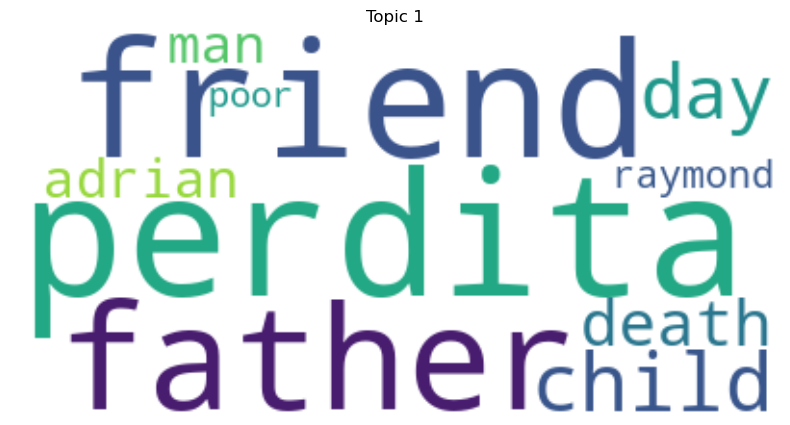

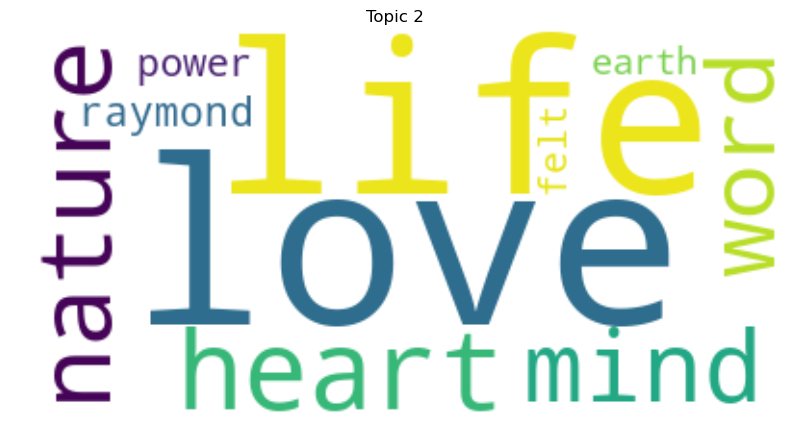

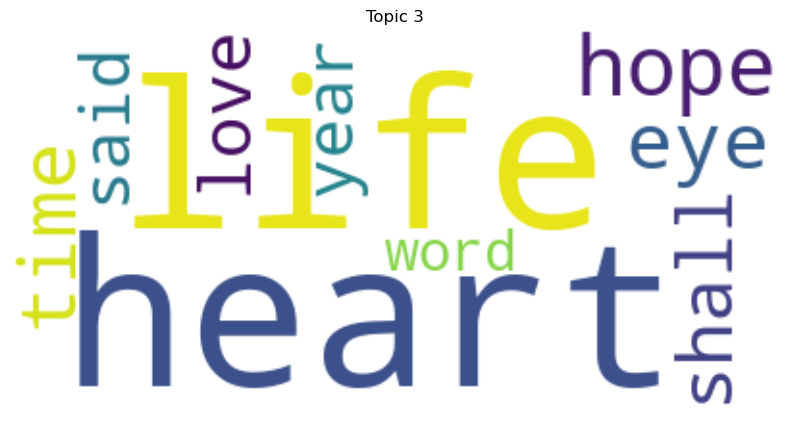

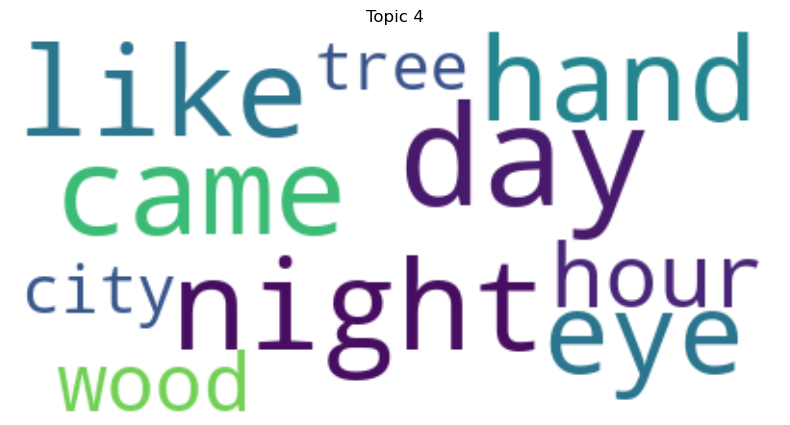

In [37]:
# Get the feature names from count vectorizer
feature_names = count_vectorizer.get_feature_names_out()

# Get the topics and their top 10 words for LDA
lda_topics = [[(feature_names[i], topic[i]) for i in topic.argsort()[:-11:-1]] for topic in lda.components_]

for i, topic in enumerate(lda_topics):
    wc = WordCloud(background_color="white", max_words=2000)
    wc.generate_from_frequencies(dict(topic))
    
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Topic {i+1}')
    plt.show()

In [38]:
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

## NMF
We now do the same thing we did for LDA:

In [41]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(horror_corpus_mws['text'])

In [42]:
nmf = NMF(n_components=4, random_state=42)
nmf.fit(tfidf)

NMF(n_components=4, random_state=42)

In [43]:
for idx, topic in enumerate(nmf.components_):
    print ("Topic ", idx, " ".join(tfidf_vectorizer.get_feature_names_out()[i] for i in topic.argsort()[:-10 - 1:-1]))


Topic  0 life man father said eyes shall death heart time day
Topic  1 raymond perdita lord adrian said time replied returned sister windsor
Topic  2 love let heart hope sympathy gave affection divinity tenderly words
Topic  3 did come know fear appear change perdita despair time answer


Now we can do the same for NMF.

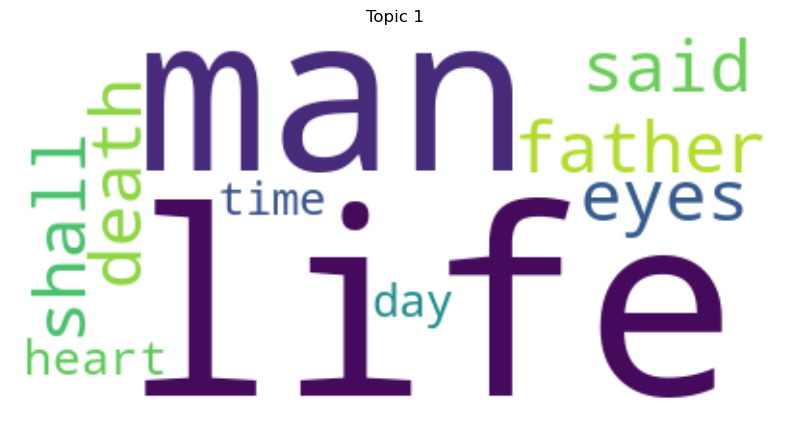

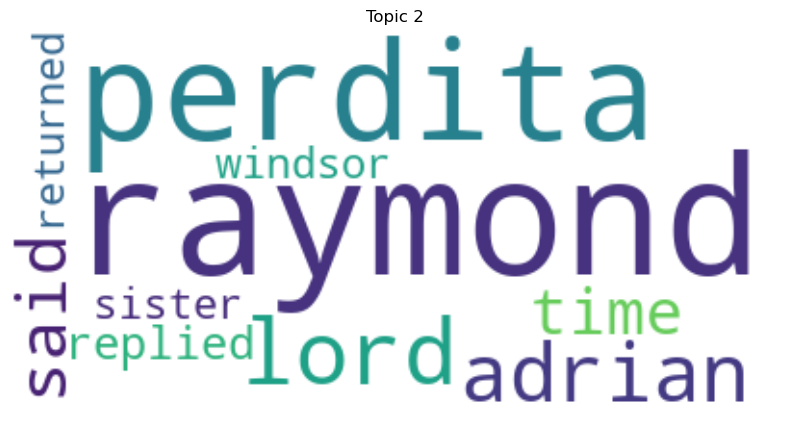

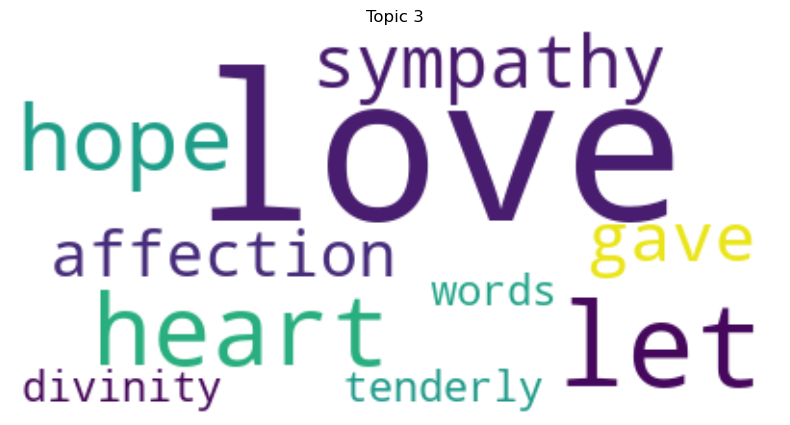

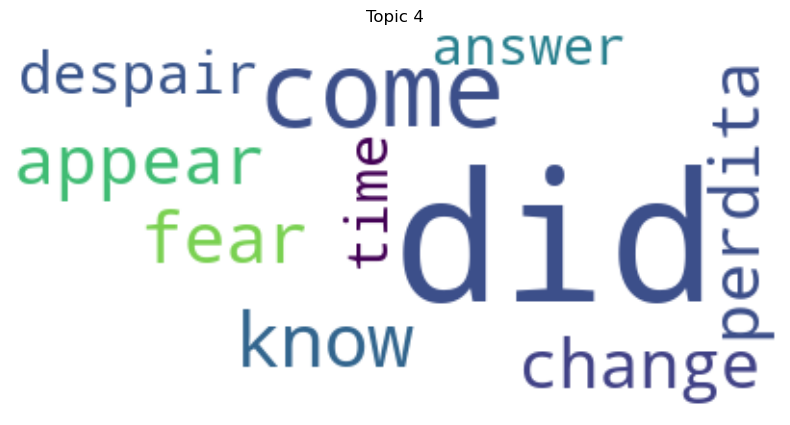

In [44]:
feature_names = tfidf_vectorizer.get_feature_names_out()

nmf_topics = [[(feature_names[i], topic[i]) for i in topic.argsort()[:-11:-1]] for topic in nmf.components_]

for i, topic in enumerate(nmf_topics):
    wc = WordCloud(background_color="white", max_words=2000)
    wc.generate_from_frequencies(dict(topic))
    
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    plt.title(f'Topic {i+1}')
    plt.show()

Here we can check the different topics for the two methods.

In [45]:
nmf_topics

[[('life', 0.612055601912497),
  ('man', 0.42093249884665446),
  ('father', 0.40713536562206926),
  ('said', 0.4030446289411679),
  ('eyes', 0.402928749058478),
  ('shall', 0.4024889919710566),
  ('death', 0.3918640801373917),
  ('heart', 0.3755104936521229),
  ('time', 0.348124649859978),
  ('day', 0.3432645155165059)],
 [('raymond', 1.4798131769884961),
  ('perdita', 0.9890930329726925),
  ('lord', 0.3098950625157727),
  ('adrian', 0.2383502979095814),
  ('said', 0.17014072203126412),
  ('time', 0.14582873976392155),
  ('replied', 0.14148601057515978),
  ('returned', 0.1149988956951932),
  ('sister', 0.11474435630005626),
  ('windsor', 0.11424697283927242)],
 [('love', 1.7601654102248243),
  ('let', 0.20508366113328208),
  ('heart', 0.14115424781675445),
  ('hope', 0.12141094750220562),
  ('sympathy', 0.12140254514131739),
  ('gave', 0.11011191004754901),
  ('affection', 0.09249638787385463),
  ('divinity', 0.08705041810943041),
  ('tenderly', 0.0843119933453882),
  ('words', 0.08390

In [46]:
lda_topics

[[('perdita', 120.18811896943112),
  ('friend', 102.55886986956884),
  ('father', 101.82914746095955),
  ('child', 98.66051983286495),
  ('day', 85.81570707535464),
  ('death', 79.14804638441043),
  ('adrian', 77.94326759226753),
  ('man', 77.10476968341088),
  ('raymond', 77.04971644726392),
  ('poor', 72.23610816963598)],
 [('love', 142.49355143385466),
  ('life', 125.52076881960177),
  ('heart', 117.32872759169378),
  ('nature', 100.83449198444343),
  ('mind', 94.25948983509514),
  ('word', 86.72018271059986),
  ('raymond', 84.88473311584322),
  ('felt', 80.53304776620494),
  ('power', 77.85099765334097),
  ('earth', 70.11515755542372)],
 [('life', 156.22723114965464),
  ('heart', 155.4713007807497),
  ('hope', 147.34797700110863),
  ('time', 124.3613290089614),
  ('eye', 123.99814640777744),
  ('shall', 113.58352099179609),
  ('love', 101.72708441805325),
  ('said', 92.1764334764952),
  ('year', 89.63333864286774),
  ('word', 83.16724934404883)],
 [('day', 103.4949608465238),
  ('n

## Interpretation of topics

The topics occuring in Shelley's works can be categorized and described as follows: 1. relationships 2. relationship between interior (feelings and emotions) and exterior (nature, landscape) 3. decisions and feelings 4. time

These topics capture the various themes and topics contained in Shelley's work. Social relationships are very important in her works. It is, therefore, no surprise that some of the words classified under topics are character names. The second topic deals with the emotions of Shelley's protagonists which always are elaborated on in relation to their environment. It, therefore, shows very well how Shelley incorporates the exterior surrounding the character with the interior on-goings in the character's mind. The third topic captures the emotional world of the character by itself and highlights that hope is an important theme occuring in many of Shelley's works. Closely related to the topic feelings is the topic time, which describes the process an development of the characters' struggles. 

The topic modelling shows that for Shelley relationships are important as are the characters' feelings and emotions. It also shows that Shelley describes the characters' feelings in relation to the outside world but also on its own. 


Personally, I think that the LDA method is more efficient in that the topics it extracted seem to be more coherent. It is also interesting that names like raymond appear in the topics. Without knowing the context of Shelley's works, it may be guessed that the character Raymond is associated with positive emotions like love (see topic 2). It also seems to be closely associated with the other people in the works like Perdita and Adrian (see topic 1). To fully interpret the results of the topic modelling, it would be necessary to know more about the works themselves.

In [47]:
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary

We then create a gensim dictionary object, which is needed for the evaluation of the coherence score.

In [49]:
dictionary = Dictionary(horror_corpus_mws['processed_text'].map(lambda x: x.split()))

In [50]:
lda_topics = [[feature_names[i] for i in topic.argsort()[:-10 - 1:-1]] for topic in lda.components_]
nmf_topics = [[feature_names[i] for i in topic.argsort()[:-10 - 1:-1]] for topic in nmf.components_]

In the next step we finally evaluate the coherence of the two models used.

In [52]:
lda_coherence = CoherenceModel(topics=lda_topics, texts=horror_corpus_mws['processed_text'].map(lambda x: x.split()), dictionary=dictionary, coherence='c_v').get_coherence()
nmf_coherence = CoherenceModel(topics=nmf_topics, texts=horror_corpus_mws['processed_text'].map(lambda x: x.split()), dictionary=dictionary, coherence='c_v').get_coherence()

print('LDA Coherence: ', lda_coherence)
print('NMF Coherence: ', nmf_coherence)


LDA Coherence:  0.5391083874676189
NMF Coherence:  0.3650954662259327


The results show that the LDA coherence score is higher than the NMF coherence score, which could possibly mean that LDA is more efficient.

## Conclusion
The analysis and especially the coherence scores show that there is a solid difference between the two methods. Of course the coherence score is to be taken with a grain of salt as topic modelling itself can be quite subjective. However, the wordclouds also show that the topics observed by LDA make more sense. It is important to add that the size of the corpus and of course the data within the corpus influence the efficiency of topic modelling.
Topic Modelling is highly dependent on the preprocessing and cleaning of the data. The parameters chosen for the method are also important and influence the results, which is why the paramters were adjusted in a hopefully more efficient way. It would, furthermore, be interesting to see the scores for the other two authors.

### Bibliography
* Kaggle Dataset: https://www.kaggle.com/competitions/spooky-author-identification/overview
* Lucija Krusic's notebook on Topic Modelling: https://github.com/lucijakrusic/programming2SS23/blob/main/natural_language_processing/NLP_topic_modelling.ipynb
* ChatGPT for descriptive texts about the authors in the dataset: https://chat.openai.com/share/6c502655-5dc9-49b9-a75f-1a436213a587